# Data Loading and preparation

Prepare for API and path

In [2]:
#All of the imports
from google.colab import drive
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import sklearn.metrics as metrics

In [3]:
! pip install kaggle

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! mkdir ~/.kaggle

In [6]:
! cp /content/drive/MyDrive/modern_analyltics/kaggle-API/kaggle.json ~/.kaggle/kaggle.json

Download dataset from Kaggle

In [7]:
! kaggle datasets download warcoder/tyre-quality-classification

Dataset URL: https://www.kaggle.com/datasets/warcoder/tyre-quality-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 2.64G/2.66G [00:28<00:00, 179MB/s]
100% 2.66G/2.66G [00:28<00:00, 99.2MB/s]


In [8]:
! unzip tyre-quality-classification.zip
! mv "Digital images of defective and good condition tyres" Digital_images

Archive:  tyre-quality-classification.zip
  inflating: Digital images of defective and good condition tyres/defective/Defective (1).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (10).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1000).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1001).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1002).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1003).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1004).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1005).jpg  
  inflating: Digital images of defective and good condition tyres/defecti

Read image data

In [9]:
## Rename unzipped folder as 'Digital_images' before running this chunk

class TyreDataset(Dataset):
    def __init__(self, defective_dir, good_dir, transform=None):
        self.filepaths = []
        self.labels = []     # Labels (0=good, 1=defective)

        # Read defective folder
        for filename in os.listdir(defective_dir):
            if filename.endswith('.jpg'):
                self.filepaths.append(os.path.join(defective_dir, filename))
                self.labels.append(1)

        # Read good folder
        for filename in os.listdir(good_dir):
            if filename.endswith('.jpg'):
                self.filepaths.append(os.path.join(good_dir, filename))
                self.labels.append(0)

        # Shuffle
        combined = list(zip(self.filepaths, self.labels))
        random.shuffle(combined)
        self.filepaths, self.labels = zip(*combined)

        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # 图像预处理
        if self.transform:
            image = self.transform(image)

        return image, label


defective_dir = '/content/Digital_images/defective'
good_dir = '/content/Digital_images/good'

# Image transofrmation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.ToTensor(),         # Tensor
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

'''
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
pre-trained from ImageNet dataset
'''

# Create dataset
dataset = TyreDataset(defective_dir, good_dir, transform=transform)



In [10]:
#we will add augmentation
augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally with a probability of 50%
    transforms.RandomRotation(20),           # Randomly rotate the image by up to 20 degrees
    transforms.RandomResizedCrop(224),       # Random crop and resize to 224x224 (standard input size for many models)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),                   # Convert PIL image to tensor
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using mean and std for pretrained models
])
dataset_augmented = TyreDataset(defective_dir, good_dir, transform=augmented)


In [11]:
len(dataset)

1856

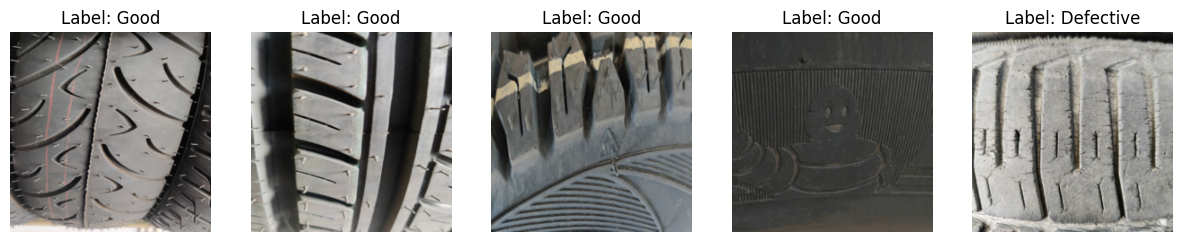

In [12]:
# Display the first 5 images with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = dataset[i]
    # Convert tensor image back to PIL image for display
    image = transforms.ToPILImage()(image)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Defective' if label == 1 else 'Good'}")
    axes[i].axis('off')

plt.show()

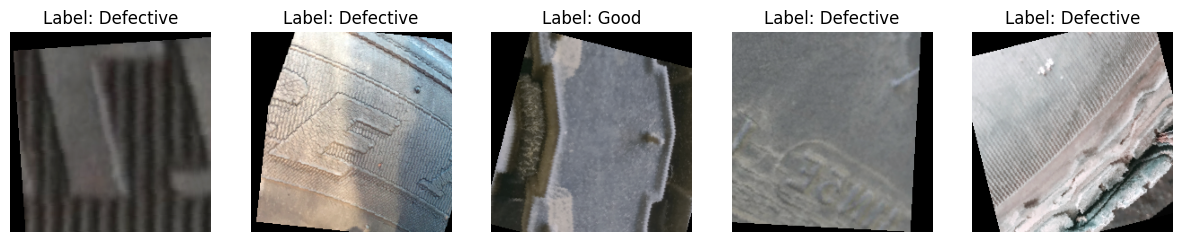

In [13]:
# Display the first 5 images with labels from augmented dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = dataset_augmented[i]
    # Convert tensor image back to PIL image for display
    image = transforms.ToPILImage()(image)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Defective' if label == 1 else 'Good'}")
    axes[i].axis('off')

plt.show()

Split training and test sets

In [14]:
from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)  # 80%
test_size = dataset_size - train_size  # 20%

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

# Create dataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

print(f"train size: {len(train_loader)}")
print(f"test size: {len(test_loader)}")


train size: 23
test size: 5


In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 224*224)

(64, 3, 224, 224)

In [16]:
# Number of samples in the train and test datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Number of batches
print(f"Train loader batches: {len(train_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train dataset size: 1484
Test dataset size: 372
Train loader batches: 23
Test loader batches: 5


In [17]:
print(f"Dataset size: {dataset_size}")
print(f"Train dataset size: {train_size}")
print(f"Test dataset size: {test_size}")


Dataset size: 1856
Train dataset size: 1484
Test dataset size: 372


In [18]:
for data, target in train_loader:
    print(f"Batch size (data): {data.size()}")
    print(f"Batch size (target): {target.size()}")
    break

Batch size (data): torch.Size([64, 3, 224, 224])
Batch size (target): torch.Size([64])


# Modeling with VGG16


VGG16 model

In [22]:
class VGG16Classifier:
    def __init__(self, num_classes=2, learning_rate=0.001, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.model = self.model.to(self.device)

        # Define loss unction and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate)

    def train(self, train_loader, test_loader, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            # Calculate training accuracy
            train_acc = correct / total
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

            # Evaluate on the test set
            self.evaluate(test_loader)

    def evaluate(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total
        print(f"Test Loss: {running_loss / len(loader):.4f}, Test Accuracy: {test_acc:.4f}")

    def save_model(self, path="vgg16_tyre_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="vgg16_tyre_model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {path}")


In [ ]:
model_vgg = VGG16Classifier(num_classes=2, learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Check the device of the model's first parameter to confirm if it's on GPU or CPU
print(next(model_vgg.model.parameters()).device)


cuda:0


In [ ]:
model_vgg.train(train_loader, test_loader, num_epochs=20)

Epoch [1/20], Loss: 0.4256, Accuracy: 0.9751
Test Loss: 0.2895, Test Accuracy: 0.9704
Epoch [2/20], Loss: 0.0772, Accuracy: 0.9872
Test Loss: 0.2622, Test Accuracy: 0.9812
Epoch [3/20], Loss: 0.0134, Accuracy: 0.9966
Test Loss: 0.2587, Test Accuracy: 0.9758
Epoch [4/20], Loss: 0.0375, Accuracy: 0.9939
Test Loss: 0.2075, Test Accuracy: 0.9866
Epoch [5/20], Loss: 0.0129, Accuracy: 0.9966
Test Loss: 0.2789, Test Accuracy: 0.9812
Epoch [6/20], Loss: 0.0663, Accuracy: 0.9933
Test Loss: 0.3656, Test Accuracy: 0.9704
Epoch [7/20], Loss: 0.0552, Accuracy: 0.9926
Test Loss: 0.4154, Test Accuracy: 0.9731
Epoch [8/20], Loss: 0.0175, Accuracy: 0.9980
Test Loss: 0.3623, Test Accuracy: 0.9839
Epoch [9/20], Loss: 0.0036, Accuracy: 0.9993
Test Loss: 0.4044, Test Accuracy: 0.9812
Epoch [10/20], Loss: 0.0000, Accuracy: 1.0000
Test Loss: 0.4026, Test Accuracy: 0.9839
Epoch [11/20], Loss: 0.0005, Accuracy: 1.0000
Test Loss: 0.3772, Test Accuracy: 0.9812
Epoch [12/20], Loss: 0.0005, Accuracy: 0.9993
Test L

# Modeling with CNN

In [19]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor) batch of 64
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
model_cnn_base = CNN()
model_cnn_base

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [21]:
model_cnn_base.cuda()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [22]:
#loss function
criterioncnn = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.SGD(model_cnn_base.parameters(), lr=0.01, momentum=0.9)

In [46]:
#training the model
num_epochs = 20

valid_loss_min = np.Inf

for epoch in range(1,num_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model_cnn_base.train()
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #optimizer
        optimizer.zero_grad()
        #forward pass
        output = model_cnn_base(data)
        #calculate the batch loss
        loss = criterioncnn(output, target)
        #backward pass
        loss.backward()
        #perform a single optimizer step
        optimizer.step()
        #update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model_cnn_base.eval()
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #forward pass
        output = model_cnn_base(data)
        #calculate the batch loss
        loss = criterioncnn(output, target)
        #update average validation loss
        valid_loss += loss.item()*data.size(0)

    #calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)

    #print trainning validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    #save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_cnn_base.state_dict(), 'model_cnn_base.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.232846 	Validation Loss: 0.589837
Validation loss decreased (inf --> 0.589837).  Saving model ...
Epoch: 2 	Training Loss: 0.726249 	Validation Loss: 0.588302
Validation loss decreased (0.589837 --> 0.588302).  Saving model ...
Epoch: 3 	Training Loss: 0.694658 	Validation Loss: 0.583206
Validation loss decreased (0.588302 --> 0.583206).  Saving model ...
Epoch: 4 	Training Loss: 0.692337 	Validation Loss: 0.579569
Validation loss decreased (0.583206 --> 0.579569).  Saving model ...
Epoch: 5 	Training Loss: 0.675378 	Validation Loss: 0.565052
Validation loss decreased (0.579569 --> 0.565052).  Saving model ...
Epoch: 6 	Training Loss: 0.699023 	Validation Loss: 0.595875
Epoch: 7 	Training Loss: 0.696013 	Validation Loss: 0.569101
Epoch: 8 	Training Loss: 0.657699 	Validation Loss: 0.552649
Validation loss decreased (0.565052 --> 0.552649).  Saving model ...
Epoch: 9 	Training Loss: 0.673220 	Validation Loss: 0.567064
Epoch: 10 	Training Loss: 0.664443 	Valida

##Test the Trained Network

In [25]:
model_cnn_base.load_state_dict(torch.load('model_cnn_base.pt'))


<ipython-input-25-63c199bb5cb3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn_base.load_state_dict(torch.load('model_cnn_base.pt'))


<All keys matched successfully>

In [26]:
#track the test lost
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
size = len(test_loader.dataset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_probs = np.zeros((size, 10))
idx = 0

model_cnn_base.eval()

#iterate over test data
for data, target in test_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_cnn_base(data)
    # calculate the batch loss
    loss = criterioncnn(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)] = pred.cpu().numpy()
    all_classes[idx:idx+len(target)] = target.cpu().numpy()
    all_probs[idx:idx+len(target)] = output.detach().cpu().numpy()
    idx = idx + len(target)

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.504266

Test Accuracy of     0: 51% (70/137)
Test Accuracy of     1: 88% (162/183)

Test Accuracy (Overall): 72% (232/320)


##Visualize a Batch of Training Data


In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [28]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(64, 3, 224, 224)

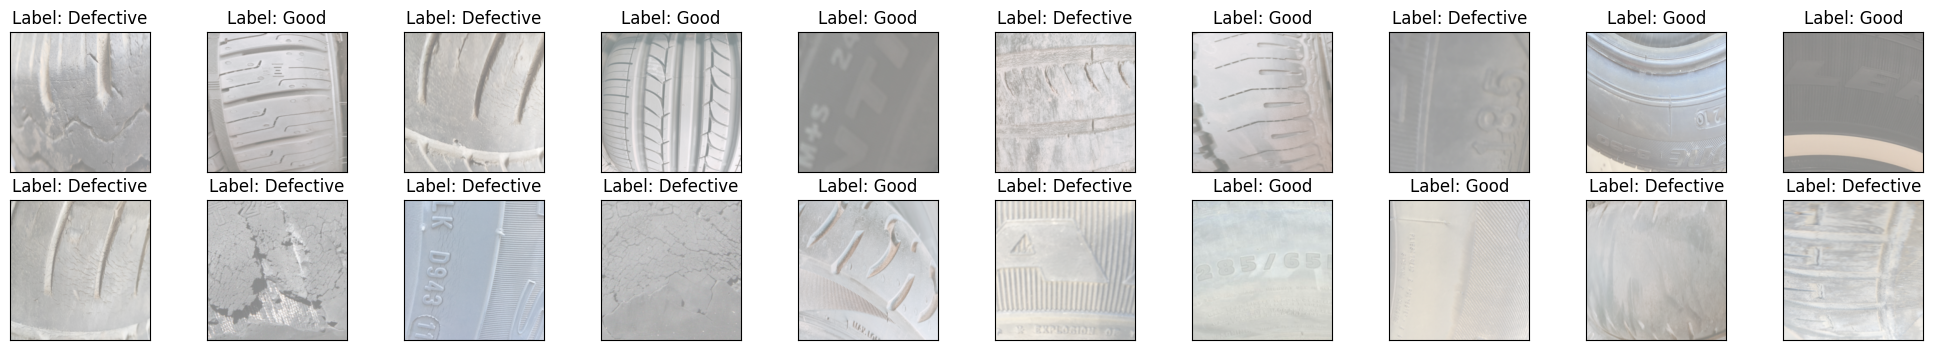

In [34]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(str(f"Label: {'Defective' if labels[idx].item()== 1 else 'Good'}"))

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
  fig = plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.tick_marks(np.arange(2))
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, ['Defective', 'Good'], rotation=45)
  plt.yticks(tick_marks, ['Defective', 'Good'])
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')